# Các mẫu thiết kế GOF : Singleton

**BS. Lê Ngọc Khả Nhi**

# Giới thiệu

Trong bài hôm nay Nhi sẽ trình bày về Singleton, một trong 23 mẫu thiết kế GOF. 

Singleton là một mẫu thiết kế thuộc nhóm "Tạo lập" (Creational), với mục tiêu là đảm bảo trong chương trình chỉ tồn tại 1 phiên bản duy nhất của một class xác định.

Việc cưỡng bức một class chỉ tồn tại độc nhất một instance (tức là ngay cả khi ta khởi tạo bao nhiêu instance mới với tên gọi khác nhau, chúng đều dẫn về một cùng một ID duy nhất) thoạt nghe có vẻ kì lạ ? Tuy nhiên trên thực tế có những hoàn cảnh mà ta cần hành vi như vậy. 

Một thí dụ đơn giản, đó là khi phân tích dữ liệu, một hay nhiều người dùng có thể thiết lập nhiều thí nghiệm với những mục tiêu khác nhau, mỗi thí nghiệm sẽ khai thác các tập hợp biến khác nhau, trên cùng một bộ dữ liệu. Ta có thể dùng thiết kế Singleton để tạo ra 1 class - thí dụ tên là **Experiment**; và chỉ cần khởi tạo 1 instance đầu tiên, thí dụ **exp_A**, để tải dataset và lưu lại trong field **_data**. 

Sau đó, ta có thể thiết lập bao nhiêu thí nghiệm tùy thích trên cùng instance này, tập hợp biến  độc lập X và phụ thuộc Y cần cho mỗi thí nghiệm sẽ được lưu lại dưới dạng list; ngay cả khi trong chương trình ta vô tình hay cố ý khởi tạo thêm nhiều instance (object) có tên gọi khác nhau như **exp_B**, **exp_C**... nhưng lúc nào ta cũng đang làm việc trên cùng một 1 instance của **Experiment**, tất cả thuộc tính đều được bảo tồn.

Thậm chí, ta có thể tiến hành đồng thời nhiều thí nghiệm trên class **Experiment** sử dụng Multithreading, như Nhi sẽ minh họa trong bài này, tuy nhiên mỗi thread đều cùng khai thác 1 instance duy nhất của class này.

# Thí dụ minh họa

Để minh họa, ta có một tình huống giả định như sau: Một nghiên cứu sinh muốn khai thác bộ dữ liệu 'biopsy', bộ dữ liệu này gồm có 9 biến từ V1 đến V9 - đại diện cho các thuộc tính giải phẫu bệnh của mẫu sinh thiết mô tuyến vú và 1 biến kết quả class ghi nhận chẩn đoán lành tính hay ác tính.

NCS này muốn thiết kế một class Experiment theo mẫu Singleton, với hành vi như sau:

+ class Experiment chỉ tồn tại dưới 1 instance duy nhất, dù ta có vô tình hay cố ý khởi tạo nhiều instance với tên gọi khác nhau, chúng thực chất chỉ là một và dẫn về cùng 1 ID.

+ class này tương thích với multithreading, cho phép xử lý đồng thời nhiều threads;

+ Khi khởi tạo lần đầu tiên, ta nhập vào đường dẫn path để tải dataset biopsy.csv từ Internet và lưu lại trong private field _data

+ method **create_experiment** cho phép thiết lập một thí nghiệm với tên là exp_name, và 2 tập biến phụ thuộc Y và độc lập X, thông tin này sẽ được lưu vào field _ exp như 1 dictionary với cấu trúc {'exp_name': {'X': list(str),'Y':list(str}}}

+ method **get_info** cho phép thực hiện thống kê mô tả và trình bày thông tin về dữ liệu tương ứng với một thí nghiệm tùy chọn

+ method **get_data** cho phép xuất ra 1 dataframe cho một thí nghiệm xác định 


# Cấu trúc module:

Sơ đồ UML của hệ thống như sau:

!['uml'](singleton_UML.png)

Nội dung của code nằm trong module state.py tại: https://github.com/kinokoberuji/Python-snipets/blob/master/GOF/Singleton/singleton.py


# Triển khai

Có nhiều cách để thiết kế Singleton class, nhưng trong bài này Nhi dùng cơ chế metaclass và kết hợp với Lock cho phép dùng multithreading:

SingletonMeta là 1 metaclass, kế thừa type của Python.

Bên trong method **_ _call_ _**:

Ta dùng Lock để đánh dấu đoạn code kiểm tra điều kiện liệu instance có tồn tại hay không ? 

Khi chương trình thi hành lần đầu tiên, chưa có một object Experiment nào cả, nhiều threads có thể được thi hành đồng thời, thread đầu tiên sẽ bị khóa và tiến vào trong đoạn code điều kiện và thi hành cho đến cùng, trong khi những thread còn lại sẽ chờ tại vị trí này. thread đầu tiên sẽ kiểm tra điều kiện và khởi tạo một object Experiment. Khi đã thoát ra khỏi đoạn code bị khóa, những thread còn lại vốn đang chờ đợi sẽ thi hành đồng thời các tiến trình sau đoạn code này; nhưng vì class Experiment đã khởi tạo 1 lần, nó sẽ không tạo thêm object nào mới nữa.

In [ ]:
class SingletonMeta(type):
    """
    Metaclass triển khai mô thức Singleton và tương thích với multithreading.
    """

    _instances = {}
    _lock: Lock = Lock()
    """
    Khi truy nhập lần đầu tiên, cho phép đồng bộ hóa các threads nhờ lock object
    """

    def __call__(cls, *args, **kwargs):
        
        with cls._lock:
            if cls not in cls._instances:
                instance = super().__call__(*args, **kwargs)
                cls._instances[cls] = instance
        return cls._instances[cls]

Tiếp theo, ta chỉ còn việc thiết kế cho class Experiment theo metaclass SingletonMeta ở trên:

In [ ]:
class Experiment(metaclass=SingletonMeta):
    _data: pd.DataFrame = None
    _exp = {}

    def __init__(self, path: str) -> None:
        if self._data is None:
            try:
                self._data = pd.read_csv(path, index_col=0)
            except FileNotFoundError:
                print(f"Lỗi: File {path} không tồn tại")
                self._data = None

    def create_experiment(self, exp_name: str,
                          X: Optional[List[str]] = None,
                          Y: Optional[List[str]] = None) -> None:

        """Hàm thiết lập 1 thí nghiệm mới"""

        if exp_name not in self._exp.keys():
            print(f"Tạo thí nghiệm mới tên là {exp_name}")
            print(f"Bao gồm tập biến X = {X}")
            print(f"và tập biến Y = {Y}")
            self._exp[exp_name] = {'X': X, 'Y': Y}
        else:
            print(f"Thí nghiệm {exp_name} đã tồn tại, hãy chọn tên khác cho thí nghiệm")

    def get_info(self, exp_name: str):

        """Hàm tóm tắt thông tin về dữ liệu cho 1 thí nghiệm"""

        if exp_name in self._exp.keys():
            X = self._exp[exp_name]['X']
            Y = self._exp[exp_name]['Y']
            df = self._data[X + Y]
            print(df.info())
            print(df.groupby(Y).describe().T)

        else:
            print(f"Lỗi: Thí nghiệm {exp_name} chưa tồn tại")

    def get_data(self, exp_name: str):

        """Hàm lấy dataframe cho 1 thí nghiệm"""

        if exp_name in self._exp.keys():
            X = self._exp[exp_name]['X']
            Y = self._exp[exp_name]['Y']
            df = self._data[X + Y]
            return df

        else:
            print(f"Lỗi: Thí nghiệm {exp_name} chưa được thiết lập")
            return None

# Sử dụng trên thực tế

Sau khi import toàn bộ module singleton, ta sẽ thử dùng nó như sau:

In [1]:
from singleton import *
import logging
import time

Đặt path = đường dẫn đến file biopsy.csv:

In [2]:
path = 'https://vincentarelbundock.github.io/Rdatasets/csv/MASS/biopsy.csv'
path 

'https://vincentarelbundock.github.io/Rdatasets/csv/MASS/biopsy.csv'

Khởi tạo lần đầu tiên instance exp_1: 

In [3]:
exp_1 = Experiment(path)

Thử khởi tạo thêm lần thứ 2, tên instance khác là exp_2:

In [4]:
exp_2 = Experiment()

Tuy nhiên, exp_2 cũng chính là exp_1, chúng có cùng id:

In [7]:
exp_1 is exp_2

True

In [8]:
exp_1

In [9]:
exp_2

Dữ liệu gốc nằm trong field _data:

In [8]:
exp_1._data

,ID,V1,V2,V3,V4,V5,V6,V7,V8,V9,class
1,1000025,5,1,1,1,2,1.0,3,1,1,benign
2,1002945,5,4,4,5,7,10.0,3,2,1,benign
3,1015425,3,1,1,1,2,2.0,3,1,1,benign
4,1016277,6,8,8,1,3,4.0,3,7,1,benign
5,1017023,4,1,1,3,2,1.0,3,1,1,benign
...,...,...,...,...,...,...,...,...,...,...,...
695,776715,3,1,1,1,3,2.0,1,1,1,benign
696,841769,2,1,1,1,2,1.0,1,1,1,benign
697,888820,5,10,10,3,7,3.0,8,10,2,malignant
698,897471,4,8,6,4,3,4.0,10,6,1,malignant


Ta khởi tạo thí nghiệm tên là "Thí nghiệm 1", tập biến X gồm V1,V2,V3, tập biến Y là "class"

In [5]:
exp_1.create_experiment('Thí nghiệm 1',['V1','V2','V3'],['class'])

Tạo thí nghiệm mới tên là Thí nghiệm 1
Bao gồm tập biến X = ['V1', 'V2', 'V3']
và tập biến Y = ['class']


In [6]:
exp_1._exp

{'Thí nghiệm 1': {'X': ['V1', 'V2', 'V3'], 'Y': ['class']}}

Dù thí nghiệm trên được tạo ra cho instance exp_1, nó cũng có thể truy nhập từ instance exp_2 (thực chất chúng là một)

In [7]:
exp_2._exp

{'Thí nghiệm 1': {'X': ['V1', 'V2', 'V3'], 'Y': ['class']}}

Dùng method get_info() để lấy thông tin dữ lịệu cho thí nghiệm có tên bất kì:

In [8]:
exp_1.get_info('Thí nghiệm 1')

Thông tin của thí nghiệm Thí nghiệm 1
<class 'pandas.core.frame.DataFrame'>
Int64Index: 699 entries, 1 to 699
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   V1      699 non-null    int64 
 1   V2      699 non-null    int64 
 2   V3      699 non-null    int64 
 3   class   699 non-null    object
dtypes: int64(3), object(1)
memory usage: 27.3+ KB
None
class         benign   malignant
V1 count  458.000000  241.000000
   mean     2.956332    7.195021
   std      1.674318    2.428849
   min      1.000000    1.000000
   25%      1.000000    5.000000
   50%      3.000000    8.000000
   75%      4.000000   10.000000
   max      8.000000   10.000000
V2 count  458.000000  241.000000
   mean     1.325328    6.572614
   std      0.907694    2.719512
   min      1.000000    1.000000
   25%      1.000000    4.000000
   50%      1.000000    6.000000
   75%      1.000000   10.000000
   max      9.000000   10.000000
V3 count  458.000000  241

Sử dụng method get_data() để trích xuất dataframe từ instance exp_1 (hoặc exp_2 cũng thế ...)

In [9]:
exp_1.get_data('Thí nghiệm 1')

,V1,V2,V3,class
1,5,1,1,benign
2,5,4,4,benign
3,3,1,1,benign
4,6,8,8,benign
5,4,1,1,benign
...,...,...,...,...
695,3,1,1,benign
696,2,1,1,benign
697,5,10,10,malignant
698,4,8,6,malignant


# Sử dụng multithreading

Tiếp theo, Nhi viết 1 hàm test_singleton thực hiện lại quy trình như trên: 

1) Khởi tạo 1 instance exp

2) Thiết lập thí nghiệm mới

3) Làm thống kê mô tả cho thí nghiệm vừa tạo

Sau đó thi hành quy trình này nhiều lần trên nhiều thread khác nhau (multithreading):

In [10]:
import seaborn as sns

In [11]:
def test_singleton(path: str, name:str, X:list,Y:list) -> None:
    logging.info(f"Thread {name} bắt đầu !")
    exp = Experiment(path)
    exp.create_experiment(name,X,Y)
    df = exp.get_data(name)
    sns.pairplot(df, hue=Y[0])
    logging.info(f"Thread {name} kết thúc !")

16:18:31: Main : Khởi tạo thread Exp_A
16:18:31: Thread Exp_A bắt đầu !
16:18:31: Main : Khởi tạo thread Exp_B
16:18:31: Thread Exp_B bắt đầu !
16:18:31: Main : Khởi tạo thread Exp_C
16:18:31: Thread Exp_C bắt đầu !
16:18:31: Main : Khởi tạo thread Exp_D
16:18:31: Thread Exp_D bắt đầu !
16:18:31: Main : trước khi khởi động thread thứ 1


Tạo thí nghiệm mới tên là Exp_A
Bao gồm tập biến X = ['V1', 'V4', 'V5']
và tập biến Y = ['class']
Tạo thí nghiệm mới tên là Exp_B
Bao gồm tập biến X = ['V3', 'V2', 'V6']
và tập biến Y = ['class']
Tạo thí nghiệm mới tên là Exp_C
Bao gồm tập biến X = ['V4', 'V6', 'V7']
và tập biến Y = ['class']
Tạo thí nghiệm mới tên là Exp_D
Bao gồm tập biến X = ['V1', 'V3', 'V4', 'V2', 'V6']
và tập biến Y = ['class']


16:18:34: Thread Exp_A kết thúc !
16:18:34: Main : thread 1 kết thúc !
16:18:34: Main : trước khi khởi động thread thứ 2
16:18:35: Thread Exp_B kết thúc !
16:18:35: Thread Exp_C kết thúc !
16:18:35: Main : thread 2 kết thúc !
16:18:35: Main : trước khi khởi động thread thứ 3
16:18:35: Main : thread 3 kết thúc !
16:18:35: Main : trước khi khởi động thread thứ 4
16:18:36: Thread Exp_D kết thúc !
16:18:36: Main : thread 4 kết thúc !


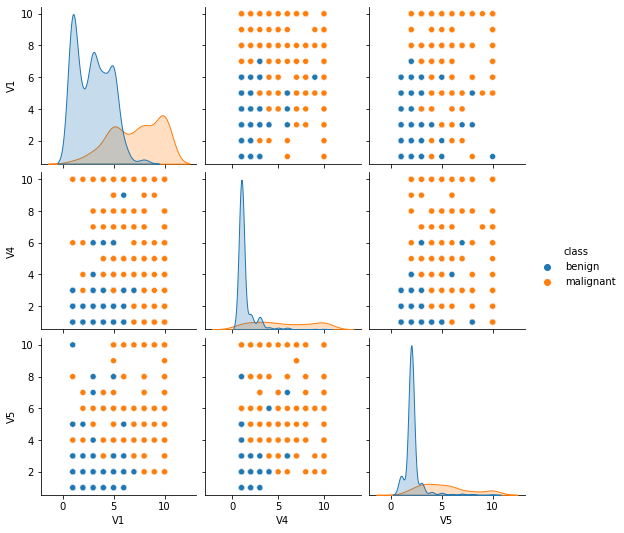

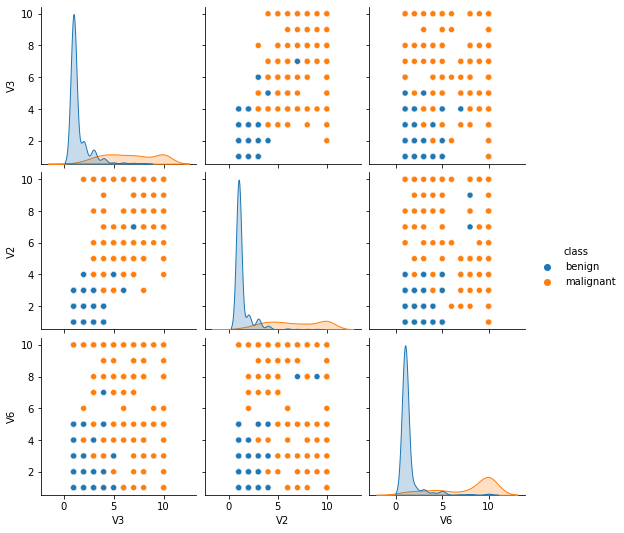

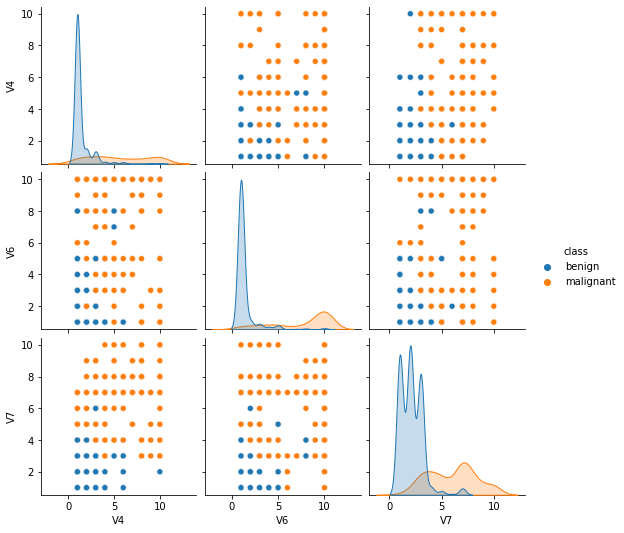

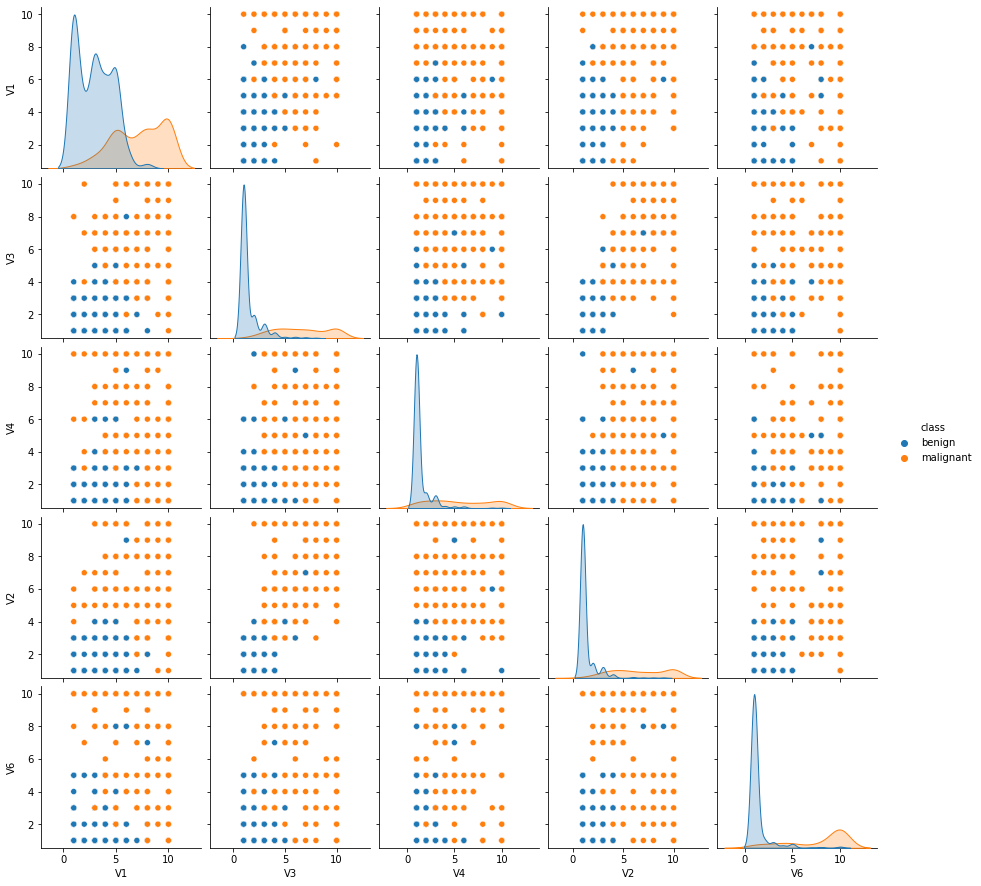

In [12]:
fm = "%(asctime)s: %(message)s"
logging.basicConfig(format=fm, level=logging.INFO,datefmt="%H:%M:%S")

models = {'Exp_A': {'X':['V1','V4','V5']},
         'Exp_B': {'X':['V3','V2','V6']},
         'Exp_C': {'X':['V4','V6','V7']},
          'Exp_D': {'X':['V1','V3','V4','V2','V6']},
         }

threads = list()

for k in models.keys():
    logging.info(f"Main : Khởi tạo thread {k}")
    x = Thread(target=test_singleton, args=(path, k, models[k]['X'], ['class']))
    threads.append(x)
    x.start()

for i, thread in enumerate(threads):
    logging.info(f"Main : trước khi khởi động thread thứ {i+1}")
    thread.join()
    logging.info(f"Main : thread {i+1} kết thúc !")

Thông tin của 4 thí nghiệm A,B,C,D mà ta vừa mô phỏng đều được lưu lại trong field _exp, của bất cứ instance nào, trước hay sau

In [10]:
exp_1._exp

{'Exp_B': {'X': ['V3', 'V2', 'V6'], 'Y': ['class']},
 'Exp_A': {'X': ['V1', 'V4', 'V5'], 'Y': ['class']},
 'Exp_D': {'X': ['V1', 'V3', 'V4', 'V2', 'V6'], 'Y': ['class']},
 'Exp_C': {'X': ['V4', 'V6', 'V7'], 'Y': ['class']}}

In [12]:
exp_2._exp

{'Exp_B': {'X': ['V3', 'V2', 'V6'], 'Y': ['class']},
 'Exp_A': {'X': ['V1', 'V4', 'V5'], 'Y': ['class']},
 'Exp_D': {'X': ['V1', 'V3', 'V4', 'V2', 'V6'], 'Y': ['class']},
 'Exp_C': {'X': ['V4', 'V6', 'V7'], 'Y': ['class']}}

In [13]:
exp_3 = Experiment()

exp_3._exp

{'Exp_B': {'X': ['V3', 'V2', 'V6'], 'Y': ['class']},
 'Exp_A': {'X': ['V1', 'V4', 'V5'], 'Y': ['class']},
 'Exp_D': {'X': ['V1', 'V3', 'V4', 'V2', 'V6'], 'Y': ['class']},
 'Exp_C': {'X': ['V4', 'V6', 'V7'], 'Y': ['class']}}

# Nhận xét

Mẫu thiết kế mà ta vừa thực hiện có những ưu điểm và nhược điểm như sau:

**Ưu điểm**

+ Chỉ cần khởi tạo instance 1 lần duy nhất, và đảm bảo tính kế thừa/khả năng cập nhật nội dung, tính duy nhất của instance này.

+ Sao lưu và kiểm soát cấu trúc của nhiều thí nghiệm khác nhau sử dụng một hệ thống danh mục chặt chẽ 

+ Tương thích với multithreading 

**Nhược điểm**:

+ các bộ phận của chương trình có thể trở nên liên thông quá mức với nhau.

+ khó thực hiện unit test.